In [1]:
%load_ext autoreload
%autoreload 2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qmmc.variables import *

## Generate data from a model

In [3]:
# Hyperpriors
mu_0, sigma_0 = Value(0), Value(1.5)
scale_0, shape_0 = Value(3), Value(3)
n = Value(5000)

# Priors and variables
mu_V_real = Normal(mu_0, sigma_0, value=0.5, name='mu_V_real')
sigma_V_real = InvGamma(scale_0, shape_0, value=3, name='sigma_V_real')
V_real = Normal(mu_V_real, sigma_V_real, size=n.value, name='V_real')

mu_WY_real = Normal(mu_0, sigma_0, value=-0.5, name='mu_WY_real')
sigma_WY_real = InvGamma(scale_0, shape_0, value=3, name='sigma_WY_real')
Y_real = Normal(mu_WY_real, sigma_WY_real, size=n.value, name='Y_real')
W_real = Normal(mu_WY_real, sigma_WY_real, size=n.value, name='W_real')


@Function
def S_real(Y=Y_real, V=V_real, W=W_real):
    d = np.empty(Y.shape[0], dtype=int)
    
    C = W  # TODO: Add multiple dealers.
    idx_done = Y <= np.minimum(C, V)
    idx_traded_away = C <= np.minimum(Y, V)
    idx_not_traded = V < np.minimum(C, Y)
    
    d[idx_not_traded] = 0
    d[idx_traded_away] = 1
    d[idx_done] = 2
    return d

p = Value(0.01)
I_real = BernoulliFlip(p, S_real, k=3, name='flip')

In [4]:
print mu_V_real.value, sigma_V_real.value
print mu_WY_real.value, sigma_WY_real.value
f = 30
print S_real.value[:f]
print I_real.value[:f]

0.5 3
-0.5 3
[1 2 2 2 1 2 1 0 2 2 2 0 0 0 1 1 0 0 2 1 1 1 2 1 2 0 2 1 1 1]
[1 2 2 2 1 2 1 0 2 2 2 0 0 0 1 1 0 0 2 1 1 1 2 1 2 0 2 1 1 1]


## Estimate model parameters from data

In [5]:
# Priors and variables
mu_V = Normal(mu_0, sigma_0, value=2, name='mu_V')
sigma_V = InvGamma(scale_0, shape_0, value=5, name='sigma_V')
V = Normal(mu_V, sigma_V, size=n.value, name='V')

Y = Value(Y_real.value)

mu_W = Normal(mu_0, sigma_0, value=2, name='mu_W')
sigma_W = InvGamma(scale_0, shape_0, value=5, name='sigma_W')
W = Normal(mu_W, sigma_W, size=n.value, name='W')

@Function
def S(Y=Y, V=V, W=W):
    d = np.empty(Y.shape[0], dtype=int)
    
    C = W
    idx_done = Y <= np.minimum(C, V)
    idx_traded_away = C <= np.minimum(Y, V)
    idx_not_traded = V < np.minimum(C, Y)
    
    d[idx_not_traded] = 0
    d[idx_traded_away] = 1
    d[idx_done] = 2
    return d

p = Value(0.01)
I = BernoulliFlip(p, S, k=3, value=I_real.value, observed=True, name='I')

In [6]:
vw_sampler = LatentSampler(V, W, I, Y, mu_V, sigma_V, mu_W, sigma_W) 
pv_sampler = NormalConjugateSampler(mu_V, sigma_V)
pw_sampler = NormalConjugateSampler(mu_W, sigma_W)

In [7]:
method = 'Gibbs'
if method == 'Gibbs':
    model = Model(variables=[mu_V, sigma_V, V, mu_W, sigma_W, W, Y, S, I],
                  samplers=[vw_sampler, pv_sampler, pw_sampler]) # 
elif method == 'MH':
    model = Model(variables=[mu_V, sigma_V, V, mu_W, sigma_W, W, Y, S, I])

In [8]:
model.samplers

{'W & V': <qmmc.variables.LatentSampler at 0x10363add0>,
 'sigma_V & mu_V': <qmmc.variables.NormalConjugateSampler at 0x10b870a10>,
 'sigma_W & mu_W': <qmmc.variables.NormalConjugateSampler at 0x10b870810>}

In [9]:
print sum(I.value != S.value)
print sum(I_real.value != S_real.value)
print sum(I_real.value != I.value)

2684
71
0


In [10]:
model.estimate(1000)

In [11]:
print sum(I.value != S.value)
print sum(I_real.value != S_real.value)
print sum(I_real.value != I.value)

0
71
0


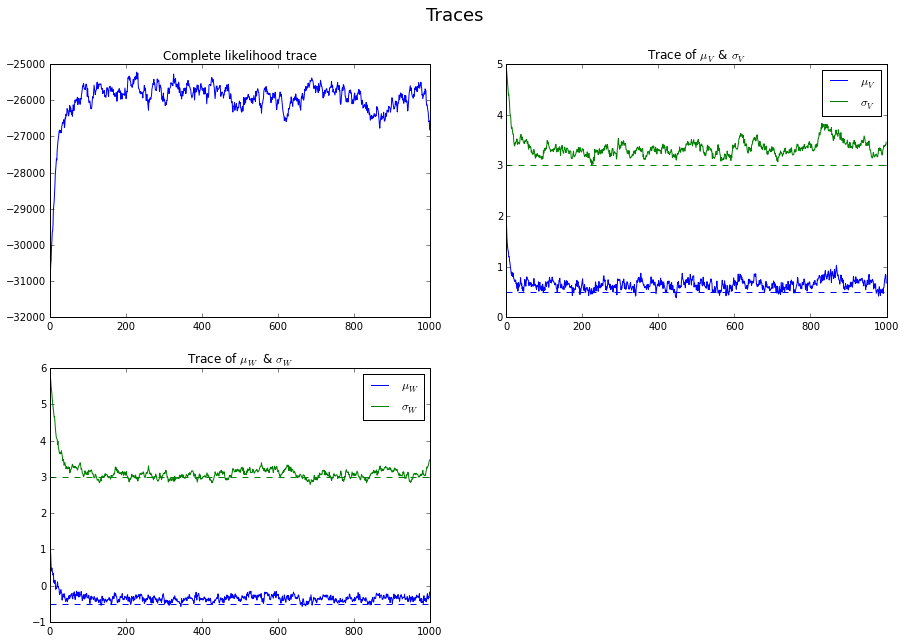

In [12]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(model.logp_history)
plt.title("Complete likelihood trace")

plt.subplot(2, 2, 2)
if method == 'Gibbs':
    plt.plot(pv_sampler.history['mu'])
    plt.plot(pv_sampler.history['sigma'])
else:
    plt.plot(model.samplers['mu_V'].get_history())
    plt.plot(model.samplers['sigma_V'].get_history())
plt.axhline(mu_V_real.value, linestyle='--')
plt.axhline(sigma_V_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_V$", r"$\sigma_V$"], loc='best')
plt.title(r"Trace of $\mu_V$ & $\sigma_V$")

plt.subplot(2, 2, 3)
if method == 'Gibbs':
    plt.plot(pw_sampler.history['mu'])
    plt.plot(pw_sampler.history['sigma'])
else:
    plt.plot(model.samplers['mu_W'].get_history())
    plt.plot(model.samplers['sigma_W'].get_history())
plt.axhline(mu_WY_real.value, linestyle='--')
plt.axhline(sigma_WY_real.value, color='g', linestyle='--')
plt.legend([r"$\mu_W$", r"$\sigma_W$"], loc='best')
plt.title(r"Trace of $\mu_W$ & $\sigma_W$")

plt.suptitle(r"Traces", size=18)
plt.show()